In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.misc import toimage
from tensorflow.keras.datasets import mnist

In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = to_categorical(Y_train, 10)
y_test = to_categorical(Y_test, 10)

In [0]:
import cv2

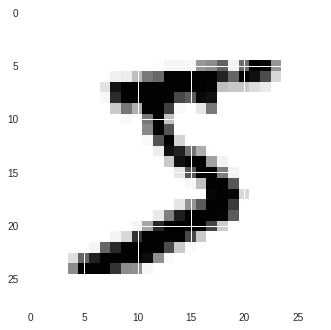

In [53]:
plt.imshow(X_train[0])

In [0]:
img = cv2.resize(X_train[0], (28,28))

In [0]:
def affine_image(img, x, y, angle, scale=1.0):
  w = 28
  h = 28

  center = (w/2, h/2)
  rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

  # 平行移動して(x, y)の位置に置く
  affine_matrix = rotation_matrix.copy()
  affine_matrix[0][2] = affine_matrix[0][2] - w/2 + x
  affine_matrix[1][2] = affine_matrix[1][2] - h/2 + y

  img_rot = cv2.warpAffine(img, affine_matrix, (w, h), flags=cv2.INTER_CUBIC)

  return img_rot

In [0]:
img_rot = affine_image(img, 8, 8, 0, 0.7)

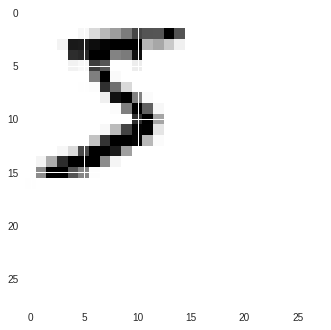

In [78]:
plt.imshow(img_rot)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

In [0]:
model = Sequential()

model.add(Convolution2D(20, 3, 3, padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(40, 3, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])


In [61]:
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.116.14.242:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14788405221327479665)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12256710846090025714)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 16137977541812742585)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15441270773648661915)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15264718940455687925)
INFO:tensorflow:*** Available Device: _De

In [0]:
tpu_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    metrics=['categorical_accuracy'])


In [63]:
tpu_model.fit(
    x=x_train.reshape(60000, 28, 28, 1), y=y_train,
    batch_size=1000, epochs=5,
    validation_data=(x_test.reshape(10000, 28, 28, 1), y_test)
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(125,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(125, 28, 28, 1), dtype=tf.float32, name='conv2d_2_input_10'), TensorSpec(shape=(125, 10), dtype=tf.float32, name='activation_5_target_50')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_2_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.3949475288391113 secs
INFO:tensorflow:Setting weights on TPU model.
59000/60000 [============================>.] - ETA: 0s - loss: 1.3443 - categorical_accuracy: 0.5952INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(125,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(125, 28, 28, 1), dtype=tf.float32, name='conv2d_2_input_10'), TensorSpec(shape=(125, 10), dtype=tf.float32, name='activation_5_t

In [64]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
def test_mnist_cnn():
    test_num = 10
    start = np.random.randint(x_test.shape[0] - test_num)
    x = x_test[start:start+test_num]
    y = y_test[start:start+test_num]

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        image = x[i]
        two_d = (np.reshape(image, (28, 28)) * 255).astype(np.uint8)
        #subplts[i].axis('off')
        subplts[i].imshow(two_d, interpolation='nearest')

    print(np.argmax(y, axis=1))

    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))

[7 8 0 7 0 6 9 3 2 4]
[7 8 0 7 0 6 9 3 2 4]


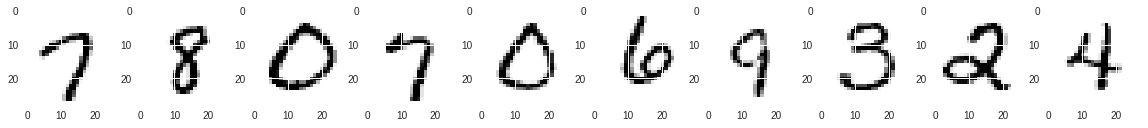

In [66]:
test_mnist_cnn()

In [0]:
import math
def test2_mnist_cnn(scale=0.5):
    size = 28
    test_num = 10
    start = np.random.randint(x_test.shape[0] - test_num)
    x = x_test[start:start+test_num]
    y = y_test[start:start+test_num]
    for i in range(10):
      padding_size = math.floor(size*scale)
      x0 = np.random.randint(padding_size) + math.floor(padding_size/2) - 1
      y0 = np.random.randint(padding_size) + math.floor(padding_size/2) - 1
      #x[i] = affine_image(x[i], x0, y0, 0, scale)
      x[i] = affine_image(x[i], 14, 14, 0, scale)

    fig, subplts = plt.subplots(ncols=10, figsize=(20, 2))
    for i in range(10):
        image = x[i]
        two_d = (np.reshape(image, (28, 28)) * 255).astype(np.uint8)
        #subplts[i].axis('off')
        subplts[i].imshow(two_d, interpolation='nearest')

    print(np.argmax(y, axis=1))

    preds = cpu_model.predict(x.reshape(test_num,28,28,1))
    print(np.argmax(preds, axis=1))

[7 3 4 0 3 9 3 2 8 9]
[7 5 4 6 3 9 3 7 0 9]


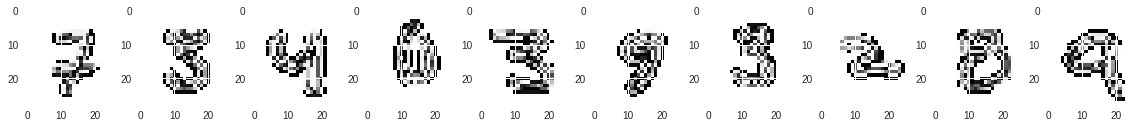

In [87]:
test2_mnist_cnn(0.9)